# HW 5 Starter Code

In [1]:
import numpy as np
import torch
import HMC
import matplotlib.pyplot as plt

We are going to make a 2D pdf as a mixture of two Gaussians, one of which we will apply a nonlinear spatial transform to make it more interesting. 

These are functions for a Gaussian pdf in $\mathbb{R}^2$ and its gradient.

In [2]:
def gauss(x, mu, omega):
    return (0.5 * omega / np.pi) * torch.exp(-0.5 * omega * torch.sum((x - mu)**2, axis = 1))

def grad_gauss(x, mu, omega):
    g = gauss(x, mu, omega)
    return (-0.5 * omega**2 / np.pi) * (g.reshape((g.shape[0], 1)).repeat(1, 2) * (x - mu))

Here is a nonlinearity $\phi : \mathbb{R}^2 \rightarrow \mathbb{R}^2$ that we'll apply to one of the Gaussians.

In [3]:
def phi(x):
    return torch.column_stack((x[:, 0], x[:, 1] + 0.25 * np.sin(4.0 * np.pi * x[:, 0])))

def dphi(x):
    return torch.column_stack((x[:, 0] + np.pi * np.cos(4.0 * np.pi * x[:, 0]) * x[:, 1], x[:, 1]))

Our final pdf will be

$$f(x) = \frac{1}{C} \exp(-U(x)),$$

where $C$ is a normalizing constant, and $U(x)$ is the energy:

$$U(x) = \ln\left(\lambda_1 \mathcal{N}\left(x; \mu_1, \omega_1^{-1} I\right) + \lambda_2 \mathcal{N}\left(\phi(x); \mu_2, \omega_2^{-1} I\right) \right),$$

where $\lambda_1, \lambda_2$ are mixture weights, $\mu_1, \mu_2 \in \mathbb{R}^2$ are the means, and $\omega_1, \omega_2 > 0$ are the precisions of Gaussian components.

In [4]:
# Parameters for the pdf
mu1 = torch.Tensor([1.0, 1.0])
mu2 = torch.Tensor([-1.0, -1.0])
omega1 = 9.0
omega2 = 9.0
lambda1 = 0.4
lambda2 = 0.6

# For taking logs near zero
epsilon = 1.0e-4

def U(x):
    e1 = lambda1 * gauss(x, mu1, omega1)
    e2 = lambda2 * gauss(phi(x), mu2, omega2)

    return -np.log(e1 + e2 + epsilon)

Here is the gradient of the energy (a.k.a., negative log pdf). You'll need this for either the Langevin or Hamiltonian Monte Carlo methods

In [5]:
def grad_U(x):
    e1 = lambda1 * gauss(x, mu1, omega1)
    e2 = lambda2 * gauss(phi(x), mu2, omega2)
    
    grad_e1 = lambda1 * grad_gauss(x, mu1, omega1)
    grad_e2 = lambda2 * dphi(grad_gauss(phi(x), mu2, omega2))

    a = (-1.0 / (e1 + e2 + epsilon)).reshape((e1.shape[0], 1))
    return a.repeat(1, 2) * (grad_e1 + grad_e2)

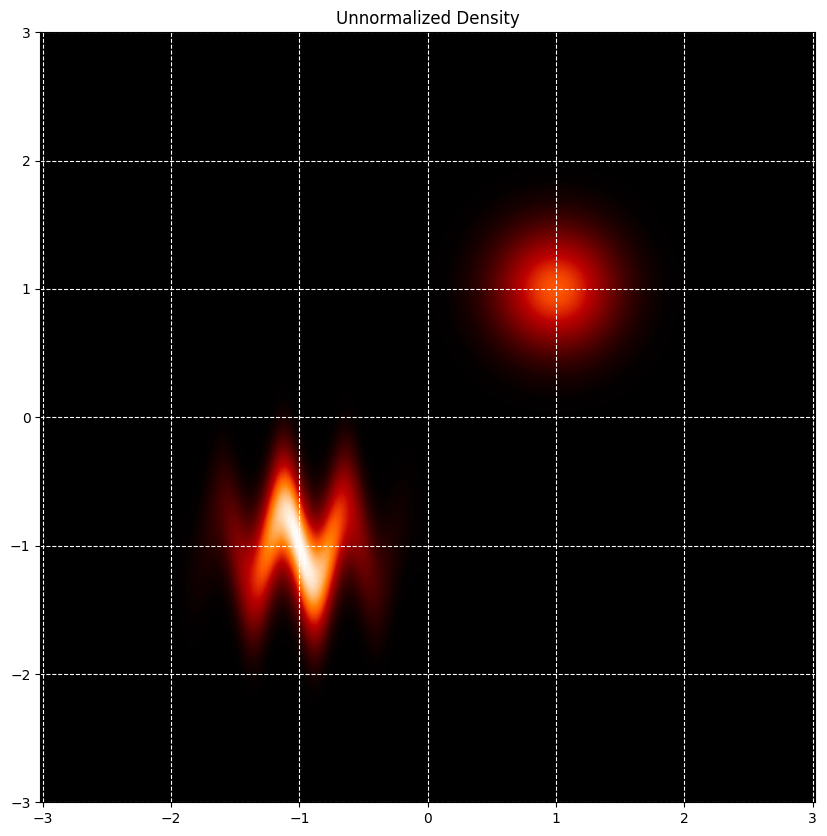

In [6]:
# Make grid for plotting
xcoord = np.linspace(-3.0, 3.0, 201)
ycoord = np.linspace(-3.0, 3.0, 201)
xx, yy = np.meshgrid(xcoord, ycoord)

# reshape xx,yy coordinates into N x 2 tensor
coords = torch.Tensor(np.column_stack((xx.flatten(), yy.flatten())))

# compute (unnormalized) density function
dens = np.exp(-U(coords))

# reshape back to the xx,yy grid
dens = dens.reshape(xx.shape).numpy()

# Contour plot
levels = np.linspace(np.max(dens) / 100, np.max(dens), 99)
plt.figure(figsize = (10, 10))
ax = plt.axes()
ax.set_facecolor("black")
plt.contourf(xx, yy, dens, levels = levels, cmap = "gist_heat")

plt.title("Unnormalized Density")
plt.grid(color='white', linestyle = '--')

plt.axis('equal')
plt.show()

In [ ]:
Repeating the density plot with an overlay of the 

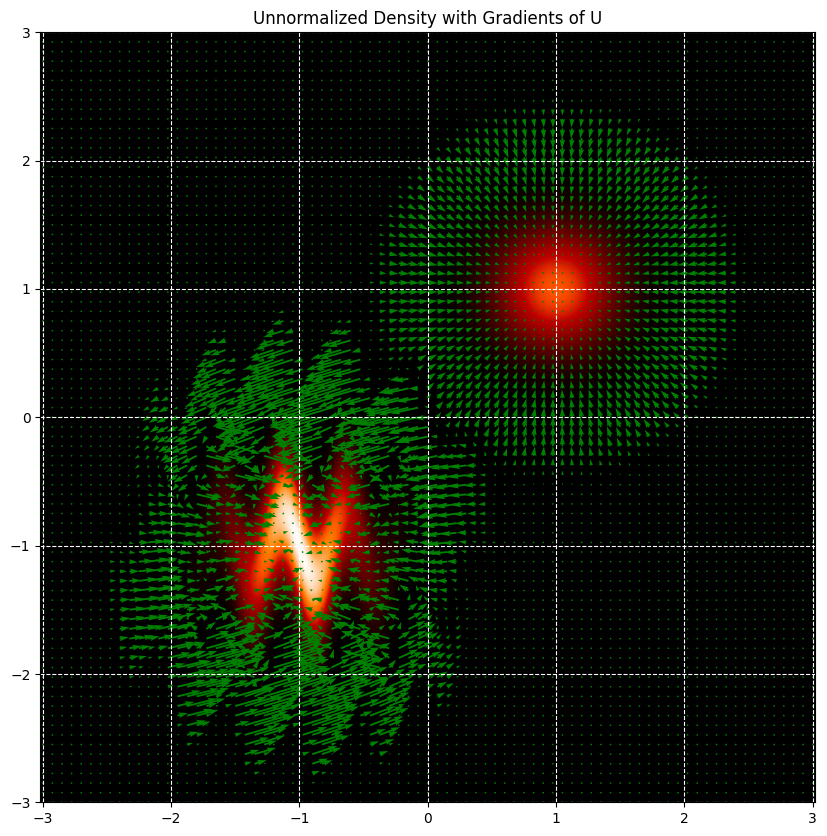

In [7]:
# Contour plot
levels = np.linspace(np.max(dens) / 100, np.max(dens), 99)
plt.figure(figsize = (10, 10))
ax = plt.axes()
ax.set_facecolor("black")
plt.contourf(xx, yy, dens, levels = levels, cmap = "gist_heat")

plt.title("Unnormalized Density with Gradients of U")
plt.grid(color='white', linestyle = '--')

plt.axis('equal')

## Gradient field plot ############################################
xcoord = np.linspace(-3.0, 3.0, 81)
ycoord = np.linspace(-3.0, 3.0, 81)
gxx, gyy = np.meshgrid(xcoord, ycoord)

# reshape xx,yy coordinates into N x 2 tensor
coords = torch.Tensor(np.column_stack((gxx.flatten(), gyy.flatten())))

# compute (unnormalized) density function
dens = np.exp(-U(coords))
grads = -grad_U(coords)

# reshape back to the xx,yy grid
grads_u = grads[:,0].reshape(gxx.shape).numpy()
grads_v = grads[:,1].reshape(gxx.shape).numpy()

plt.quiver(gxx, gyy, grads_u, grads_v, color='g', scale = 1000)
#####################################################################

plt.show()